In [ ]:
!pip install transformers torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 30.7 MB/s 
     |████████████████████████████████| 6.6 MB 62.9 MB/s 
     |████████████████████████████████| 163 kB 72.4 MB/s 


In [ ]:
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
import itertools
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
model = BertModel.from_pretrained("bert-large-cased")
model = model.cuda()

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train = pd.read_csv("./train.csv")

In [ ]:
qs = {}
for q, ty in zip(train["question"].values, train["type"].values):
  if ty not in qs:
    qs[ty] = []
  qs[ty].append(q)

ty_id_map = {ty: id for id, ty in enumerate(qs)}
inv_ty_id_map = {ty_id_map[x]:x for x in ty_id_map}

In [ ]:
qes = {}
batch_size = 32
for ty in qs:
  qes[ty] = None
  for start in tqdm(range(0, int(np.ceil(len(qs[ty])/batch_size)))):
    batch = qs[ty][start*batch_size : (start+1)*batch_size]
    inputs = tokenizer(batch, return_tensors='pt', padding=True)
    for i in inputs:
      inputs[i] = inputs[i].cuda()
    outputs = model(**inputs)
    sreps = outputs[0][:, 0, :].cpu().detach().numpy()
    if qes[ty] is None:
      qes[ty] = sreps
    else:
      qes[ty] = np.concatenate((qes[ty], sreps), axis = 0)

100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


In [ ]:
for ty in qs:
  assert len(qs[ty]) == len(qes[ty])

In [ ]:
X = np.concatenate([qes[x] for x in qes], axis = 0)
y = np.array(list(itertools.chain.from_iterable([[ty_id_map[ty]]*len(qes[ty]) for ty in qes])))

In [ ]:
feat_cols = [ 'feat'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (34132, 1026)


In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
N = len(df)
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

In [ ]:
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 34132 samples in 0.024s...
[t-SNE] Computed neighbors for 34132 samples in 104.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34132
[t-SNE] Computed conditional probabilities for sample 2000 / 34132
[t-SNE] Computed conditional probabilities for sample 3000 / 34132
[t-SNE] Computed conditional probabilities for sample 4000 / 34132
[t-SNE] Computed conditional probabilities for sample 5000 / 34132
[t-SNE] Computed conditional probabilities for sample 6000 / 34132
[t-SNE] Computed conditional probabilities for sample 7000 / 34132
[t-SNE] Computed conditional probabilities for sample 8000 / 34132
[t-SNE] Computed conditional probabilities for sample 9000 / 34132
[t-SNE] Computed conditional probabilities for sample 10000 / 34132
[t-SNE] Computed conditional probabilities for sample 11000 / 34132
[t-SNE] Computed conditional probabilities for sample 12000 / 34132
[t-SNE] Computed conditional probabilities for 

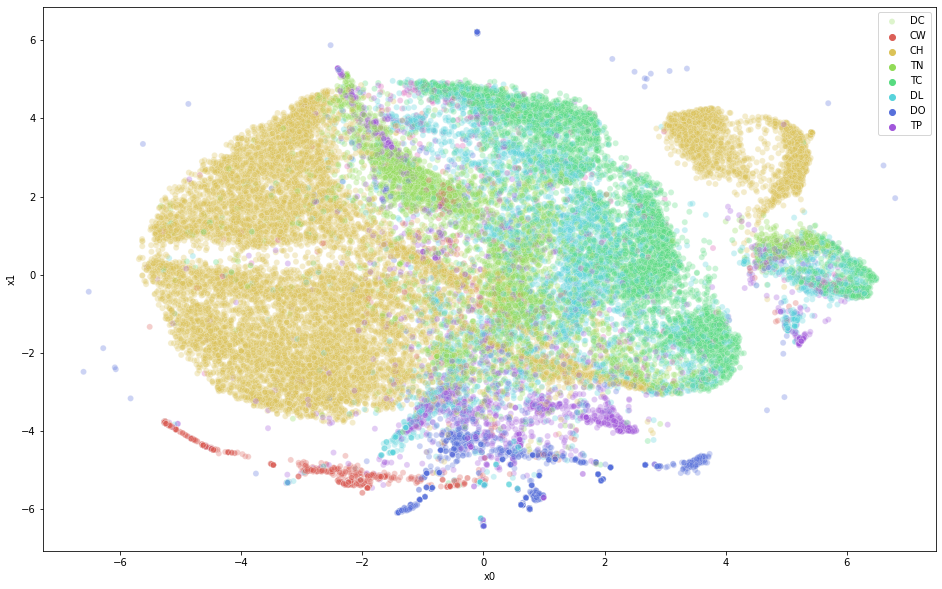

In [ ]:
df_subset['x0'] = tsne_results[:,0]
df_subset['x1'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x0", y="x1",
    hue="y",
    palette=sns.color_palette("hls", 8),
    data=df_subset,s
    legend="full",
    alpha=0.3
)
plt.legend(labels = [inv_ty_id_map[x] for x in range(8)])
plt.savefig("qembed_bert_clustering.png", dpi=120)